# ARIMA (& soon GARCH) time-series modelling 
This notebook demonstrates how to research and backtest a trading strategy using ARIMA and GARCH
## 1. Dependencies

In [214]:
%load_ext zipline
%matplotlib notebook
#%matplotlib inline
import itertools
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from zipline.api import symbol, order_percent, schedule_function, date_rules, time_rules, symbol, record

from utils.plotting import plot_acf

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


## 2. Preprocess time-series data
### 2.1 extract historical data from zipline backtester
I use Zipline for backtesting, and when only researching I use an ugly hack below to extract the time-series of a symbol into a variable outside of the backtester.  
The data used is Zipline's quantopian-quandl bundle. Which is Daily stock data from [Quandl](https://www.quandl.com/search)

In [175]:
ts = None
ticker = None

def before_trading_start(context, data):
    # extract historical data from zipline backtester to use outside of backtester
    global ts
    global ticker
    ticker = 'MCD'
    ts = pd.DataFrame(data.history(symbol(ticker), 'price', 500, '1d'))
    ts = ts.rename(index=str, columns={symbol(ticker): ticker})
    ts.index = pd.to_datetime(ts.index)
    
    print('ts head:')
    print(ts.head())
    print('ts tail:')
    print(ts.tail())
    
%zipline --bundle quantopian-quandl --start 2015-6-3 --end 2015-6-4 -o backtest.pickle

ts head:
               MCD
2013-06-10  93.030
2013-06-11  91.814
2013-06-12  91.824
2013-06-13  92.422
2013-06-14  91.992
ts tail:
              MCD
2015-05-28  96.48
2015-05-29  95.93
2015-06-01  96.22
2015-06-02  96.29
2015-06-03  96.52
ts head:
               MCD
2013-06-11  91.814
2013-06-12  91.824
2013-06-13  92.422
2013-06-14  91.992
2013-06-17  92.291
ts tail:
              MCD
2015-05-29  95.93
2015-06-01  96.22
2015-06-02  96.29
2015-06-03  96.52
2015-06-04  96.31


/anaconda/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/anaconda/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-06-03 20:00:00+00:00,NaN,0.0,NaN,0.002649,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2015-06-04 20:00:00+00:00,0.0,0.0,0.0,-0.005823,0.124596,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0


### 2.2 Calculate log-return
ARIMA will use log-returns instead of the actual time-series as input

In [176]:
# log scale
ts['log'] = np.log(ts)

# log return
ts['logret'] = ts['log'] - ts['log'].shift()
ts = ts[1:]

print('ts head:')
print(ts.head())
print('ts tail:')
print(ts.tail())

ts head:
               MCD       log    logret
2013-06-12  91.824  4.519874  0.000109
2013-06-13  92.422  4.526365  0.006491
2013-06-14  91.992  4.521702 -0.004663
2013-06-17  92.291  4.524947  0.003245
2013-06-18  93.235  4.535123  0.010177
ts tail:
              MCD       log    logret
2015-05-29  95.93  4.563619 -0.005717
2015-06-01  96.22  4.566637  0.003018
2015-06-02  96.29  4.567364  0.000727
2015-06-03  96.52  4.569750  0.002386
2015-06-04  96.31  4.567572 -0.002178


## 3. Visualization of data
The log returns and its correlogram is plotted below for inspection.  
The correlogram visualizes autocorrelations at different lags of the time-series. Read more about it here:  
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

<IPython.core.display.Javascript object>


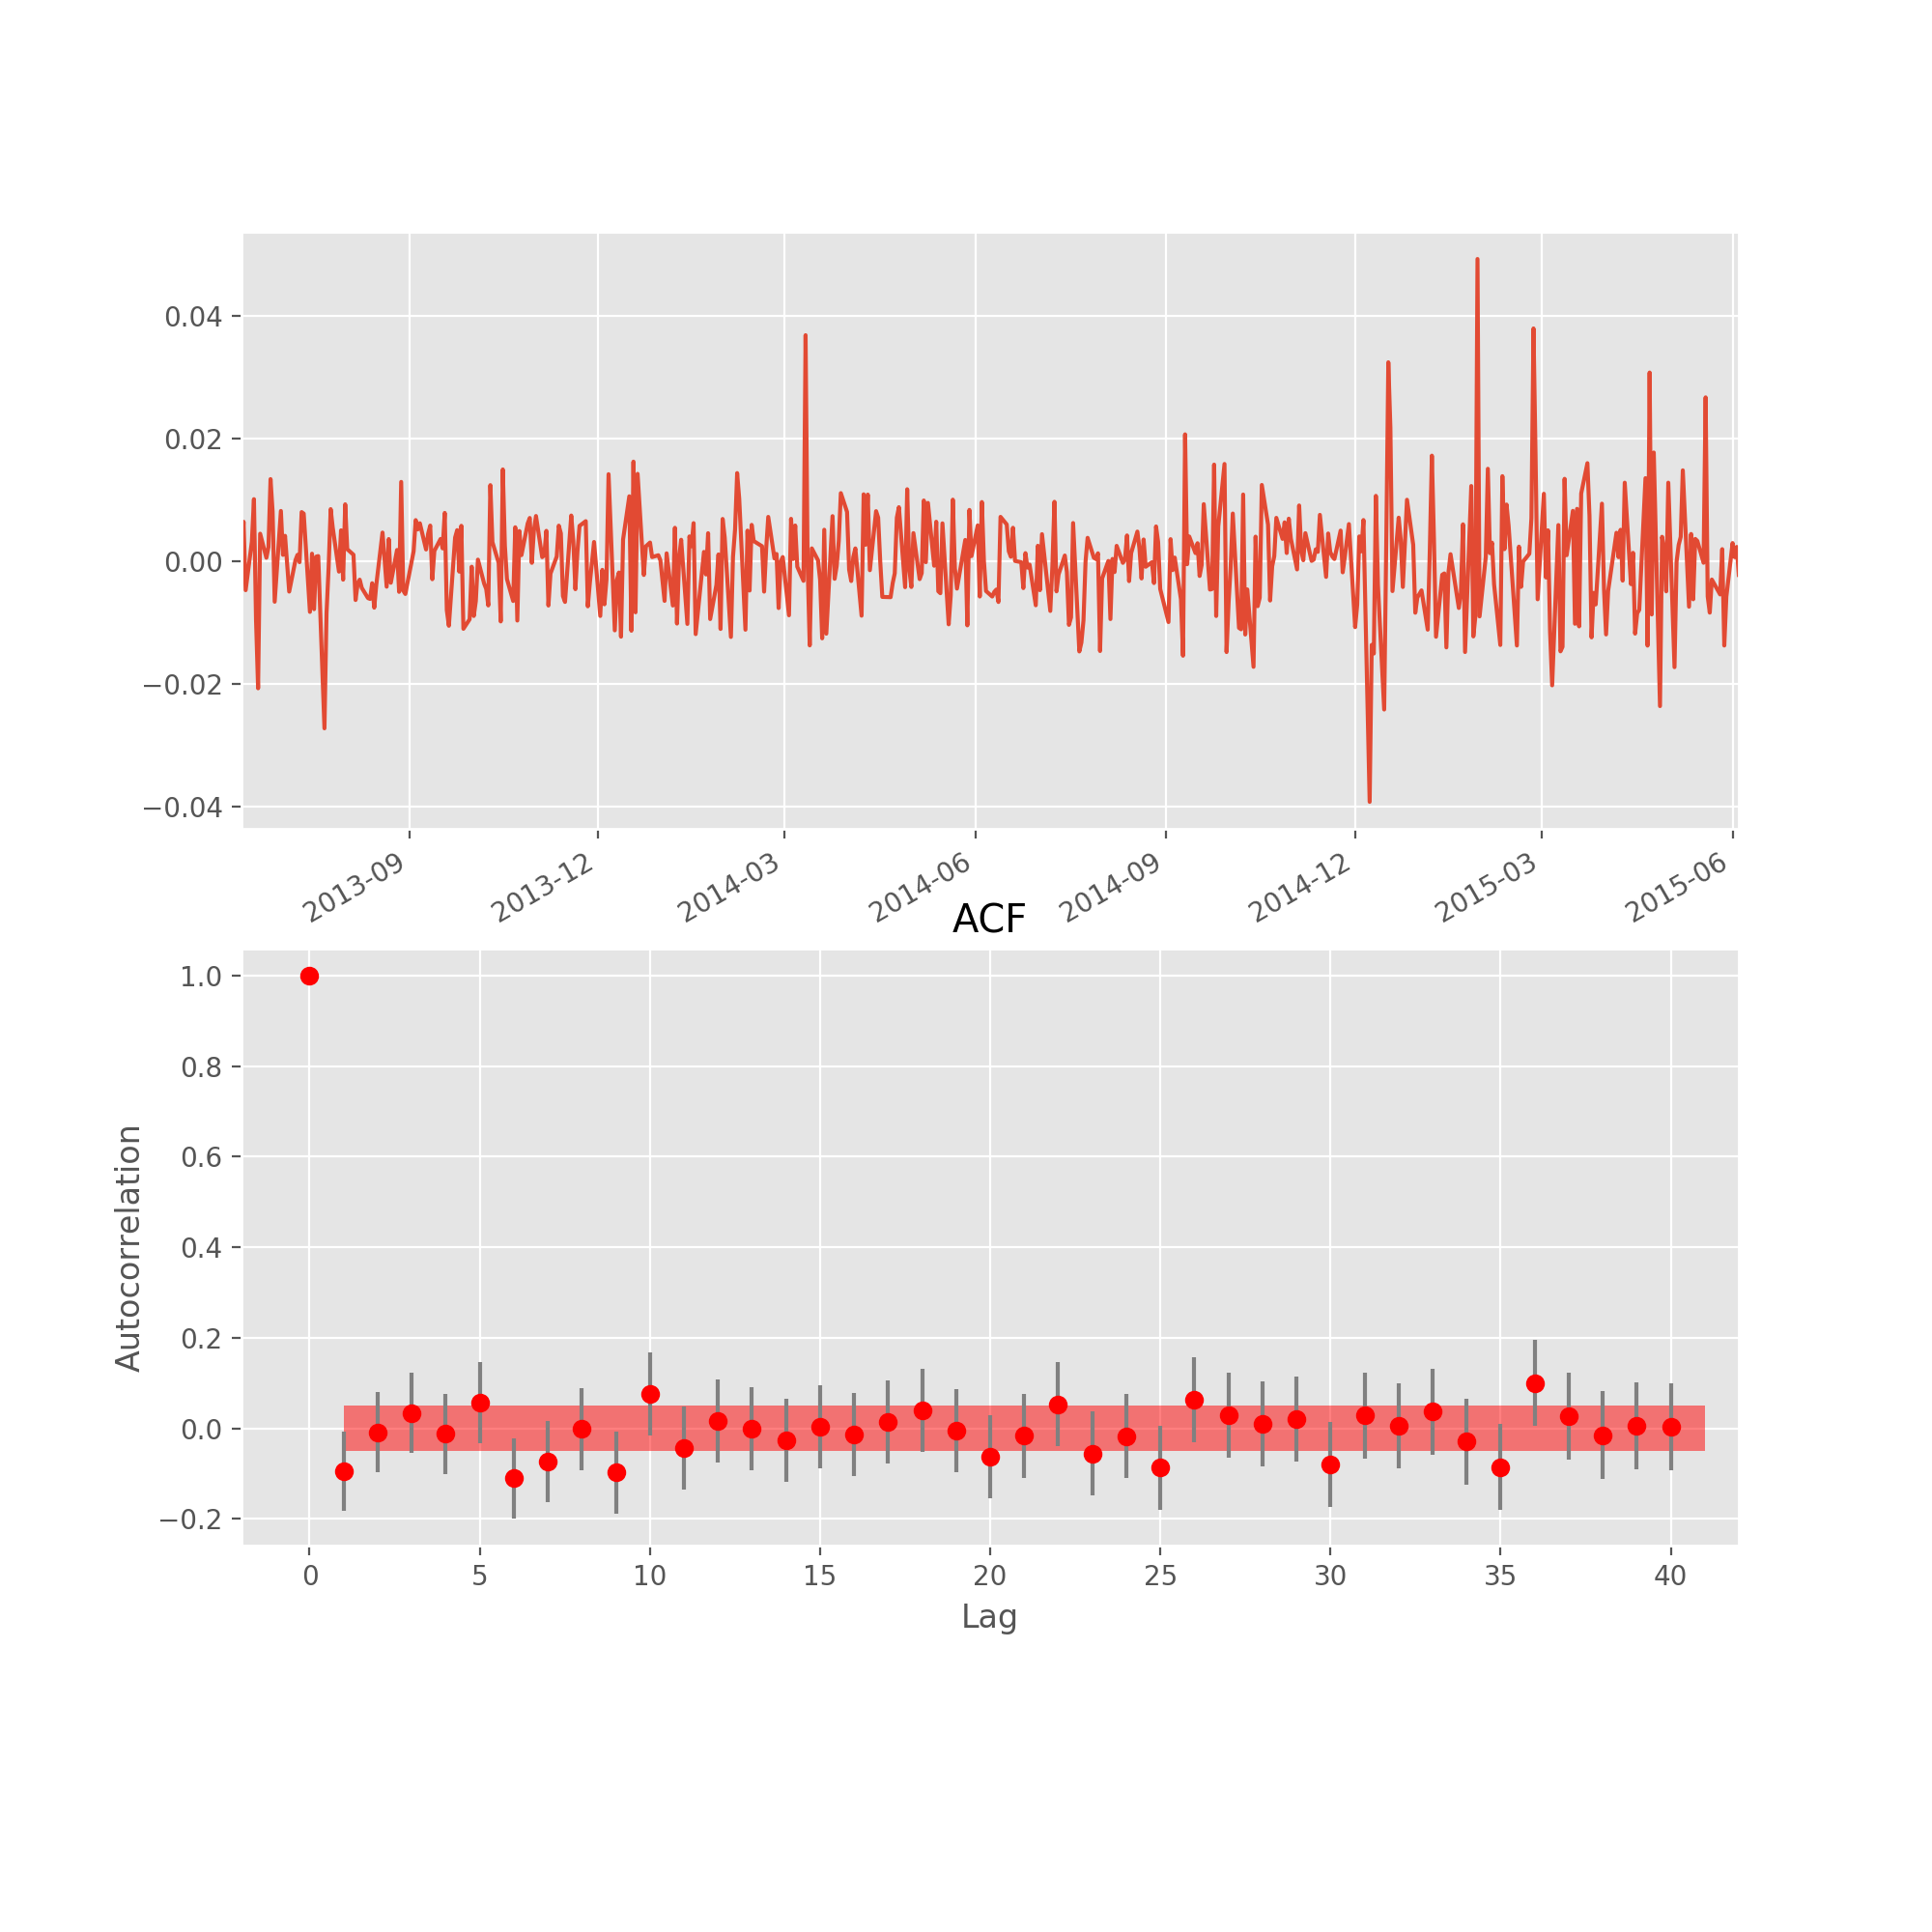

Number of autocorrelated lags: 14
Number of lags where 0 is not included in confidence interval: 4


In [177]:
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

# plot log return
ts['logret'].plot(ax=ax1)

plot_acf(ts['logret'])

fig.show()

## 4. Model fitting and Hyperparameter search
Using grid search, the hyperparameters `p`, `d` and `q` are optimized with two evaluation metrics:  
 * [Akaike Information Criterion (AIC)](http://www.statisticshowto.com/akaikes-information-criterion/)
 * [Bayesian Information Criterion (BIC)](http://www.statisticshowto.com/bayesian-information-criterion/)  
 
The best model according to AIC is saved and the best model according to BIC. As a final step, the model with the least parameters is chosen.  

In [241]:
def fit_arima(X, p_max=20, d_max=1, q_max=20):
    
    ps, ds, qs = range(p_max + 1), range(d_max + 1), range(q_max + 1)
    best_params_aic, best_model_aic = None, None
    best_params_bic, best_model_bic = None, None
    for p, d, q in itertools.product(ps, ds, qs):
        if p == 0 and q == 0:
            continue
        try:
            model_arima = sm.tsa.ARIMA(X, (p,d,q)).fit()

            # save best model according to AIC
            if not best_model_aic or model_arima.aic < best_model_aic.aic:
                best_params_aic = (p,d,q)
                best_model_aic = model_arima

            # save best model according to BIC
            if not best_model_bic or model_arima.bic < best_model_bic.bic:
                best_params_bic = (p,d,q)
                best_model_bic = model_arima
        except:
            pass
            #print('could not fit ({},{},{})'.format(p,d,q))

    # chose model with fewest params
    if sum(best_params_aic) < sum(best_params_bic):
        best_params, best_model = best_params_aic, best_model_aic
    else:
        best_params, best_model = best_params_bic, best_model_bic

    print('----Summary----')
    print('Best model AIC: {}'.format(best_params_aic))
    print('Best model BIC: {}'.format(best_params_bic))
    print('Best overall model: {}'.format(best_params))
    
    # TODO: returns only from aic atm. Too many models fail to converge
    return best_model_aic, best_params_aic

best_model, best_params = fit_arima(ts['logret'], 5, 1, 5)

## 5. Analyze results
Model is a good fit if all p values are above 0.05!  

best model params:  (3, 0, 3)
p values:  ['0.05276', '0.1454', '0.2722', '0.2722', '0.3975', '0.2947', '0.1136', '0.1666', '0.1287', '0.1584', '0.2149', '0.2731', '0.3353', '0.3936', '0.4562', '0.5126', '0.5636', '0.4225', '0.459', '0.4374']
number of p values below 0.05:  0
                              ARMA Model Results                              
Dep. Variable:                 logret   No. Observations:                  499
Model:                     ARMA(3, 3)   Log Likelihood                1674.950
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 23 Sep 2018   AIC                          -3333.901
Time:                        15:41:33   BIC                          -3300.200
Sample:                    06-12-2013   HQIC                         -3320.675
                         - 06-04-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-----------

/anaconda/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


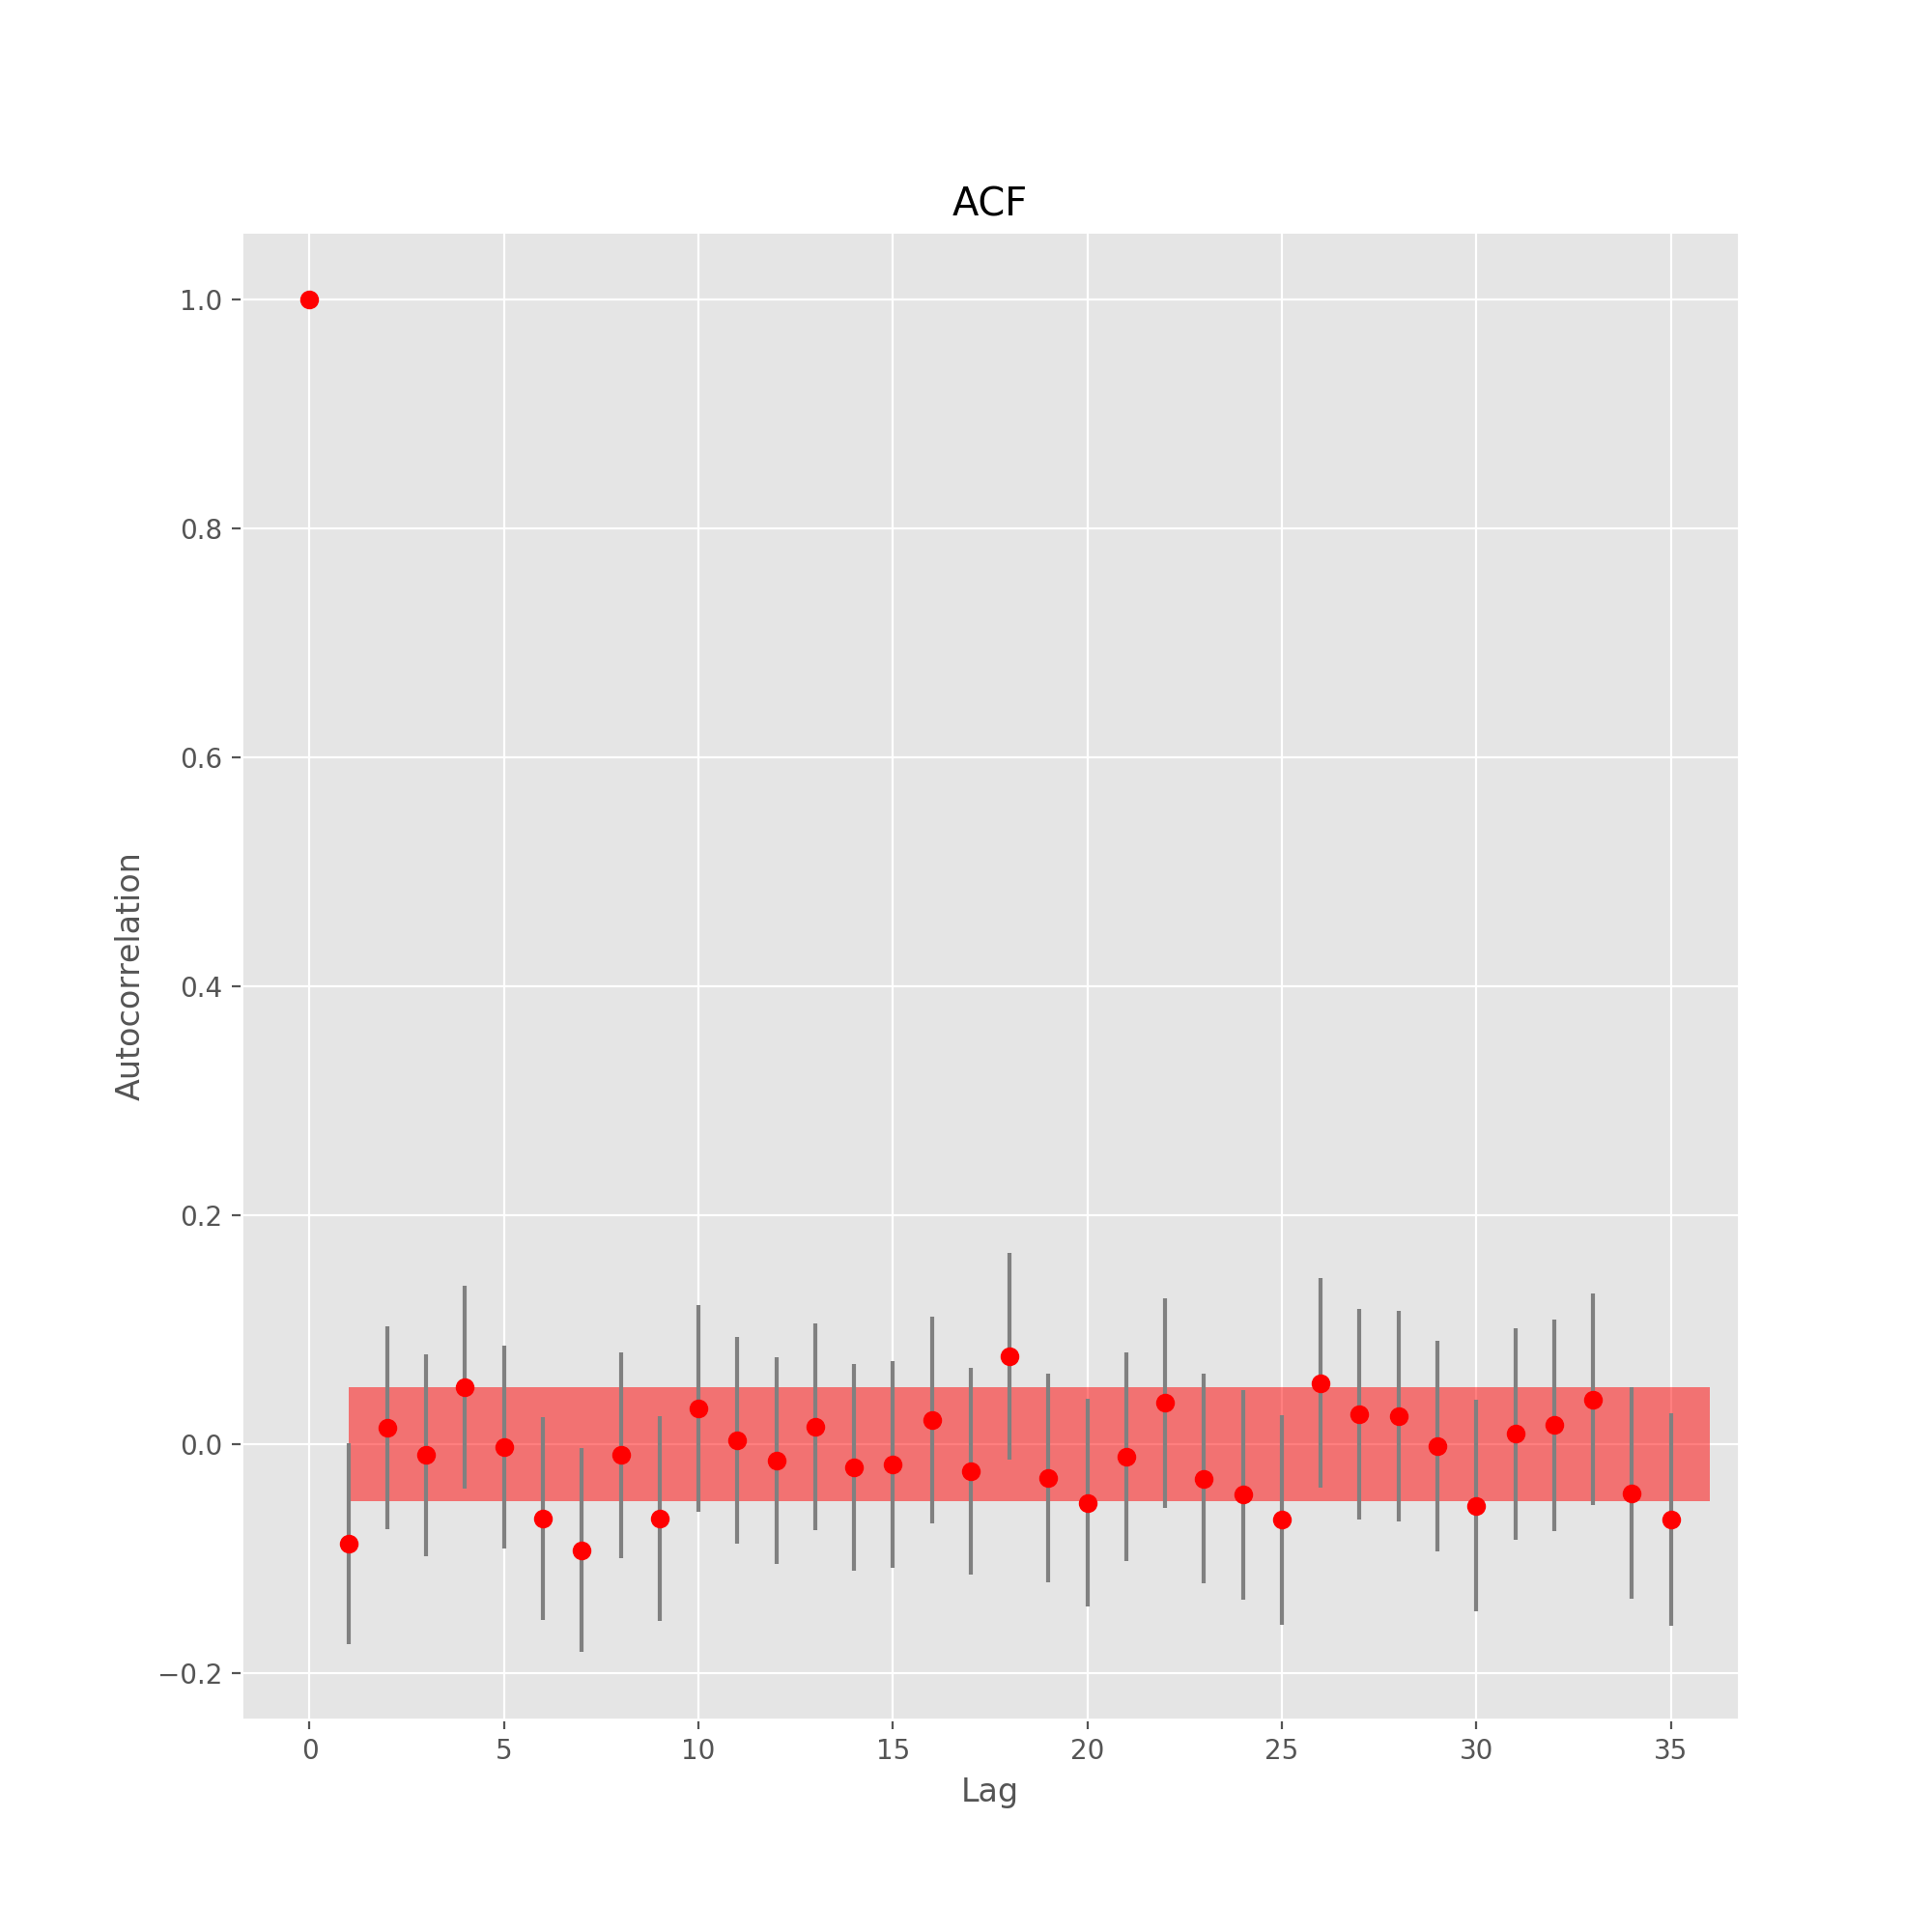

Number of autocorrelated lags: 10
Number of lags where 0 is not included in confidence interval: 1


In [179]:
print('best model params: ',best_params)
_, p_values = sm.stats.diagnostic.acorr_ljungbox(best_model.resid, lags=20, boxpierce=False)
print('p values: ', list(map(lambda x: "{:.4}".format(x),p_values)))
print('number of p values below 0.05: ', len([p for p in p_values if p < 0.05]))
print(best_model.summary())

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plot_acf(best_model.resid,nlags=35)

Sample predictions and create simple in-sample backtest

<IPython.core.display.Javascript object>


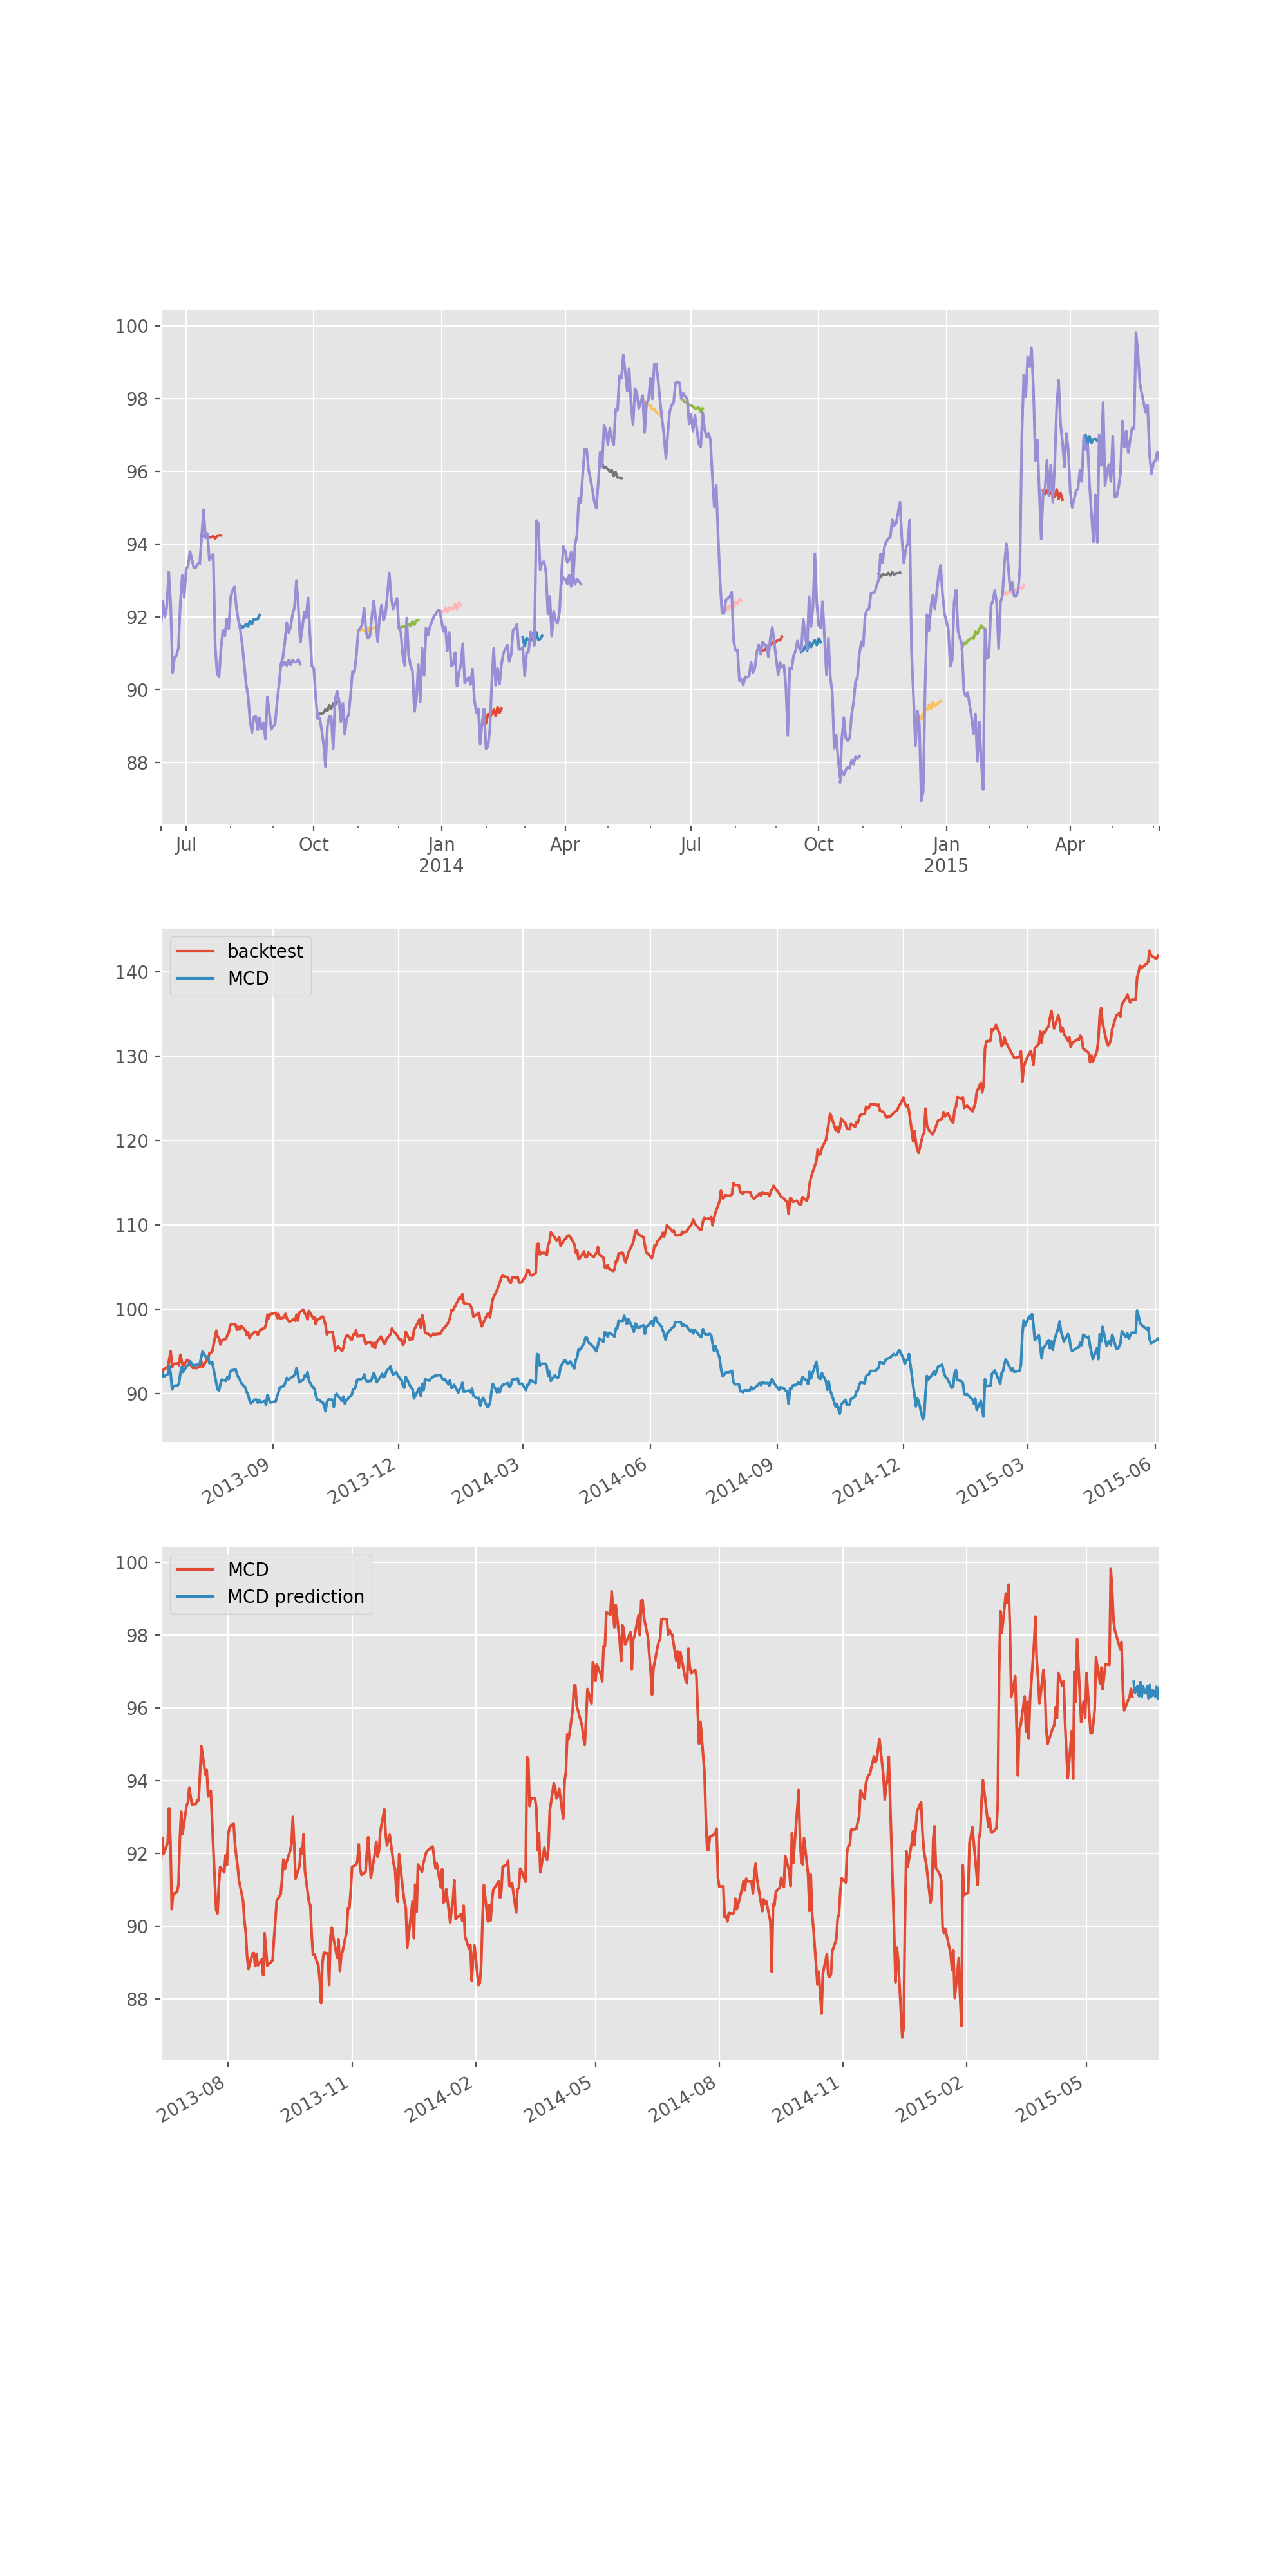

NOTE! THIS IS IN-SAMPLE BACKTEST RESULT WITHOUT TRADING COSTS


In [192]:
fig=plt.figure(figsize=(10,20))

""" Sample forecasts for different dates """
ax=fig.add_subplot(311)
step = 20
for start in range(step, len(ts['log']) - step, step):
    preds = best_model.predict(start=start, end=start + 10)
    ret = [ts['log'][start]]
    for pred in preds:
        ret.append(ret[-1] + pred)
    ret = pd.Series(np.exp(ret[1:]), index=preds.index)
    ret.plot(ax=ax)
ts[ticker].plot(ax=ax, label=ticker)

""" Simple backtest """
ax=fig.add_subplot(312)
signal = []
step = 1
# simple signal generation and backtest
for start in range(0,len(ts['log']),step):
    preds = best_model.predict(start=start, end=start)
    signal.append(np.sign(preds[0]))
ret = (ts[ticker] - ts[ticker].shift()) * np.array(signal)
ret[0] = ts[ticker][0]
ret.cumsum().plot(ax=ax, label='backtest')
ts[ticker].plot(ax=ax, label=ticker)
ax.legend()
print('NOTE! THIS IS IN-SAMPLE BACKTEST RESULT WITHOUT TRADING COSTS')

""" Forecasting the future """
ax=fig.add_subplot(313)
preds = best_model.forecast(steps=20)[0]
ret = [ts['log'][-1]]
ret_dates = [ts.index[-1]]
for pred in preds:
    ret.append(ret[-1] + pred)
    ret_dates.append(ret_dates[-1] + pd.Timedelta(days=1))
ret = pd.Series(np.exp(ret[1:]), index=ret_dates[1:])
ts[ticker].plot(ax=ax, label=ticker)
ret.plot(ax=ax, label=ticker + ' prediction')
ax.legend()


## 6. Backtest with zipline
The strategy is to simply to long if the prediction is positive, and short if the prediction is negative

----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (5, 0, 4)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 4)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 4)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 4)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 4)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (2, 0, 0)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 0)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 0)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 0)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 4)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 0)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (2, 0, 0)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (0, 0, 1)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (3, 0, 2)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best model AIC: (4, 0, 3)
Best model BIC: (0, 0, 1)
Best overall model: (0, 0, 1)
----Summary----
Best

<IPython.core.display.Javascript object>


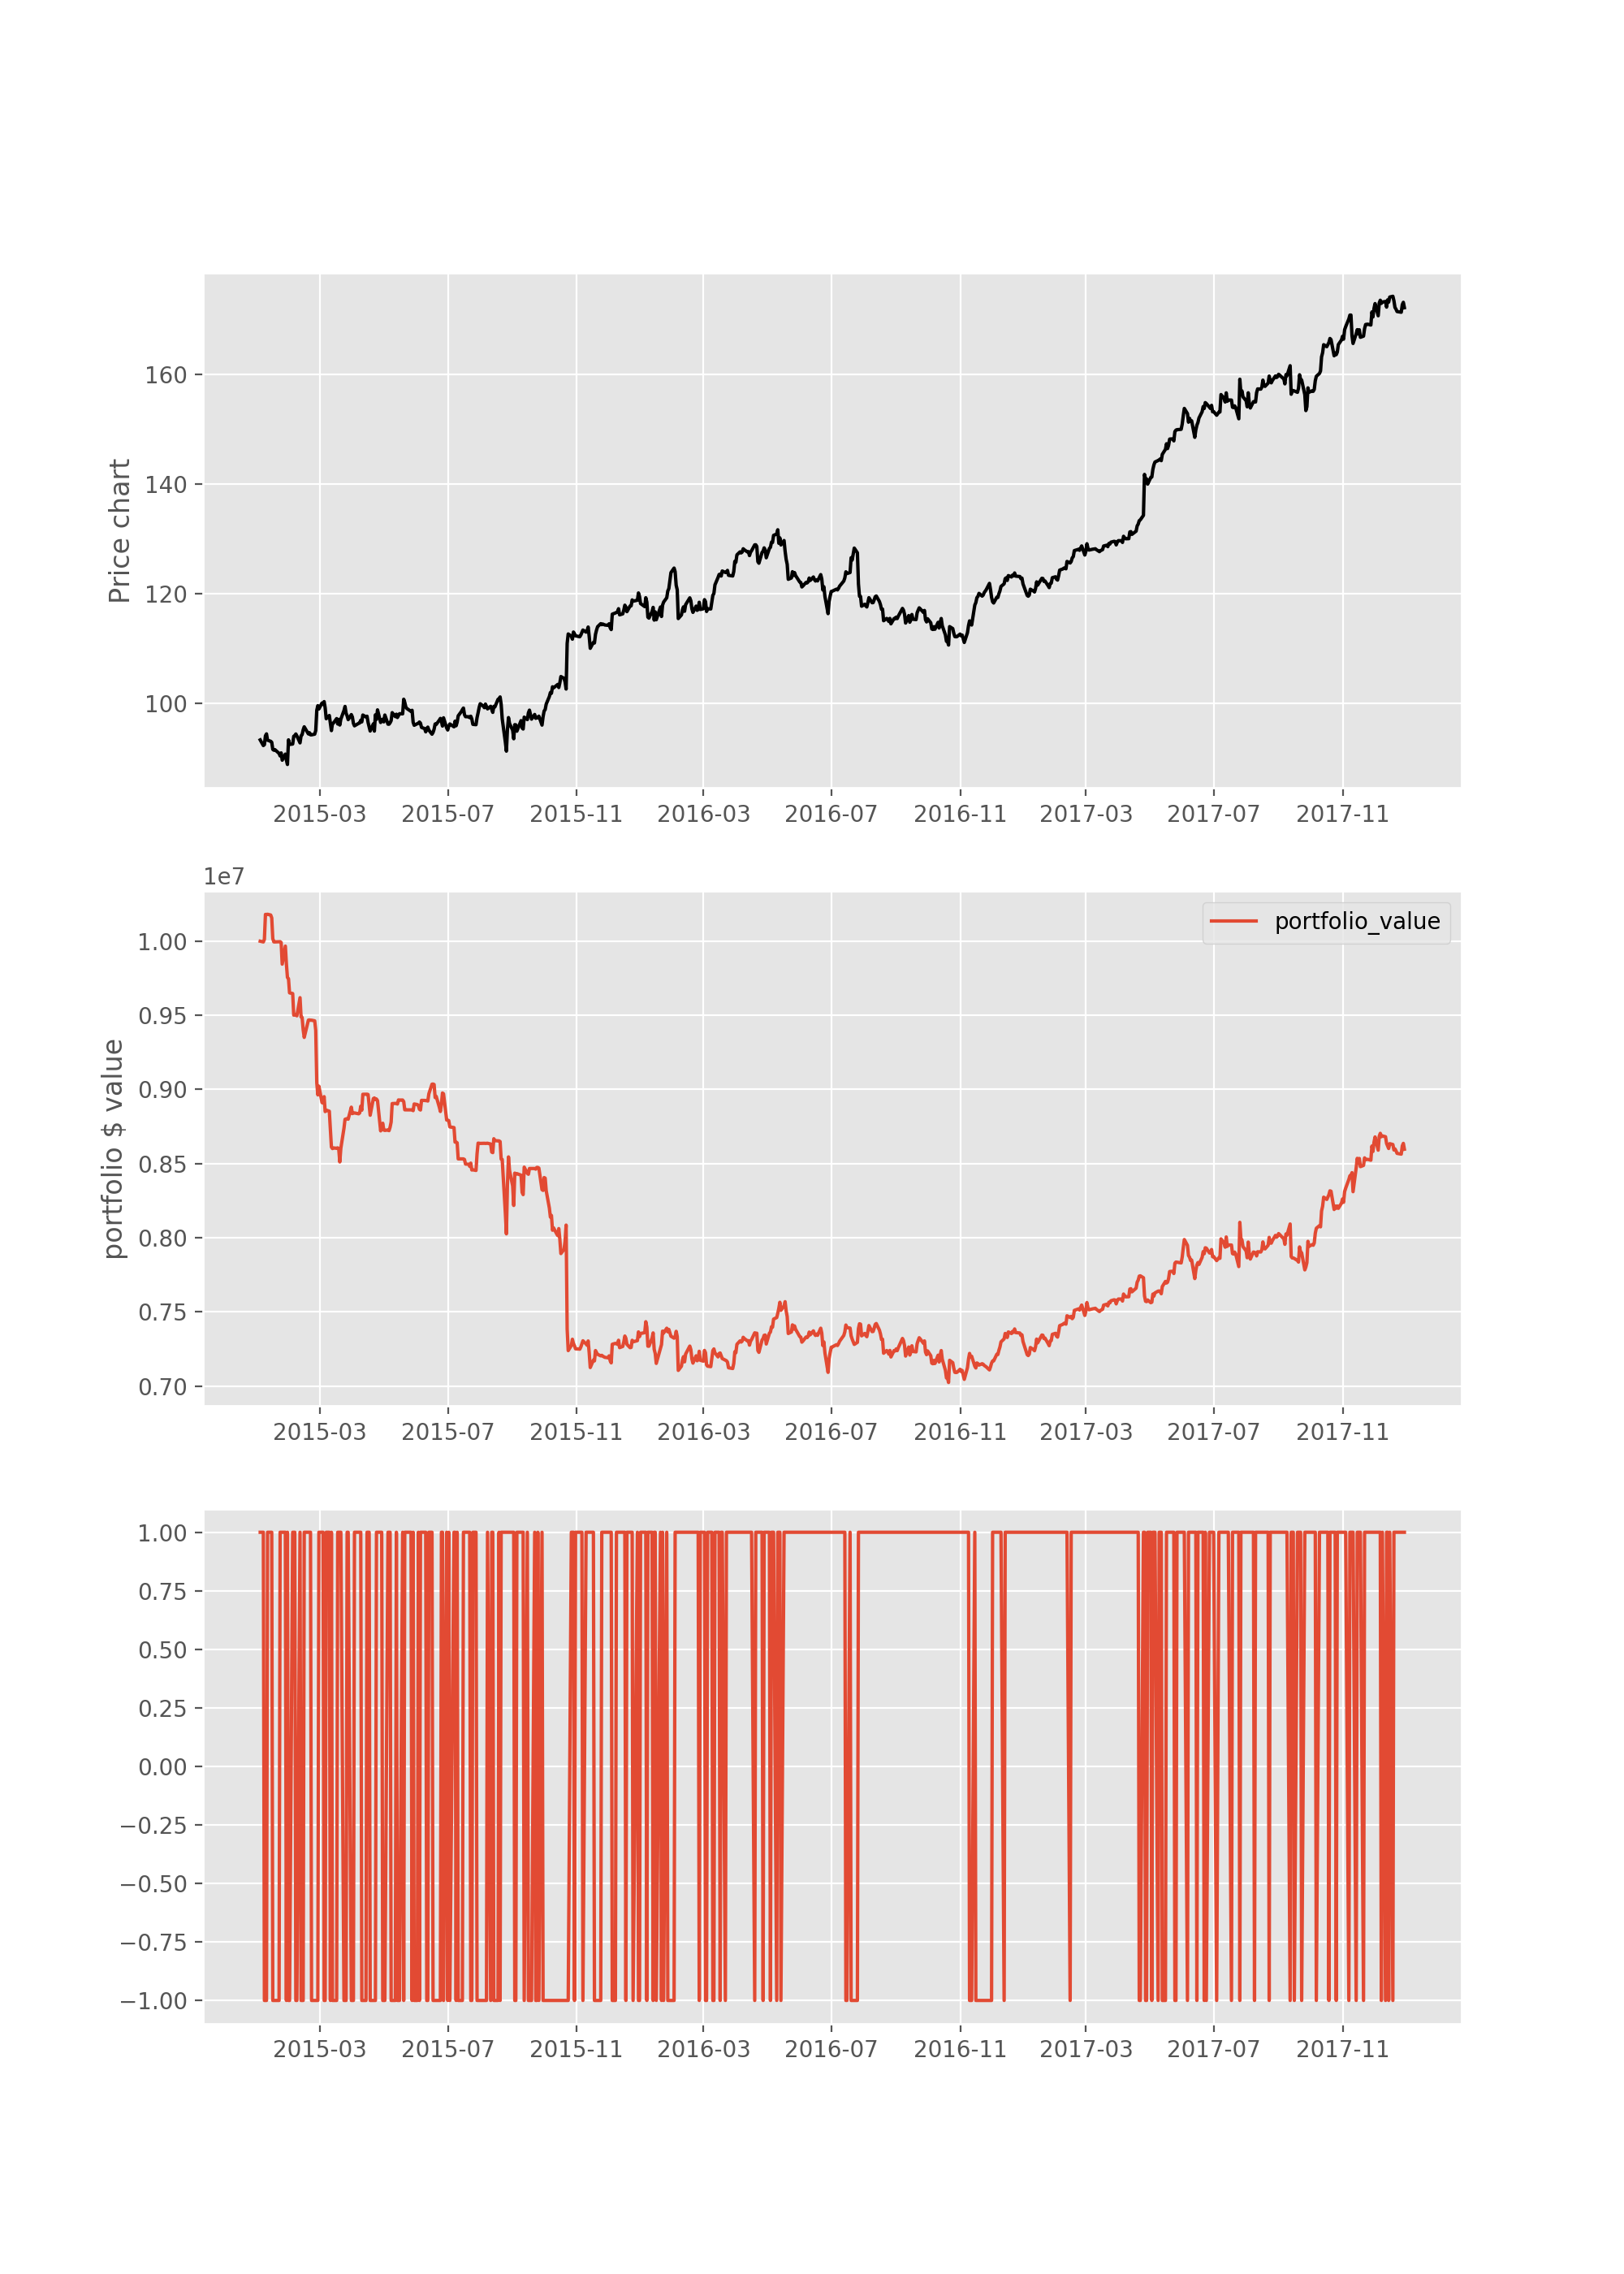

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_value,shorts_count,signal,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,NaN,-0.000535,NaN,NaN,0.000000e+00,1.000000e+07,0.00,0.00,...,0.00,0,1,NaN,1.000000e+07,0.00,0.00,1,[],0.0
2015-01-05 21:00:00+00:00,0.005671,-0.000505,0.003885,-0.018585,0.196720,0.028827,-9.894598e+06,1.054018e+05,9889546.21,9889546.21,...,0.00,0,1,-11.224972,1.000000e+07,0.00,0.00,2,"[{'amount': 107227, 'price': 92.276115, 'order...",0.0
2015-01-06 21:00:00+00:00,0.019448,0.001318,0.176014,-0.027829,0.139106,0.027730,0.000000e+00,1.054018e+05,9907774.80,9907774.80,...,0.00,0,-1,23.921196,1.054018e+05,9889546.21,9889546.21,3,[],0.0
2015-01-07 21:00:00+00:00,0.130204,0.018061,1.656133,-0.015715,0.206973,0.530328,1.018238e+07,1.028778e+07,-107171.40,-107171.40,...,-107171.40,1,-1,283.426553,1.054018e+05,9907774.80,9907774.80,4,"[{'amount': -108367, 'price': 93.962995, 'orde...",0.0
2015-01-08 21:00:00+00:00,0.117294,0.018021,0.883278,0.001752,0.236042,0.216790,0.000000e+00,1.028778e+07,-107570.40,-107570.40,...,-107570.40,1,-1,252.195917,1.028778e+07,-107171.40,-107171.40,5,[],0.0
2015-01-09 21:00:00+00:00,0.107296,0.018152,0.817428,-0.006276,0.218112,0.229021,0.000000e+00,1.028778e+07,-106259.40,-106259.40,...,-106259.40,1,1,231.869362,1.028778e+07,-107570.40,-107570.40,6,[],0.0
2015-01-12 21:00:00+00:00,0.100185,0.017656,0.753389,-0.014060,0.203322,0.240598,-1.016486e+07,1.229239e+05,10053636.92,10053636.92,...,0.00,0,1,150.576914,1.028778e+07,-106259.40,-106259.40,7,"[{'amount': 109232, 'price': 93.056505, 'order...",0.0
2015-01-13 21:00:00+00:00,0.096031,0.015710,0.621985,-0.016834,0.188302,0.243833,0.000000e+00,1.229239e+05,10034180.36,10034180.36,...,0.00,0,1,43.340319,1.229239e+05,10053636.92,10053636.92,8,[],0.0
2015-01-14 21:00:00+00:00,0.122336,0.001767,0.242549,-0.022769,0.177394,0.295959,0.000000e+00,1.229239e+05,9894741.68,9894741.68,...,0.00,0,-1,0.763352,1.229239e+05,10034180.36,10034180.36,9,[],0.0
2015-01-15 21:00:00+00:00,0.115998,-0.000474,0.232506,-0.031722,0.170558,0.298772,9.994969e+06,1.011789e+07,-122631.96,-122631.96,...,-122631.96,1,-1,-0.083689,1.229239e+05,9894741.68,9894741.68,10,"[{'amount': -109434, 'price': 91.33431, 'order...",0.0


In [243]:
def initialize(context):
    context.ticker = symbol('MCD')
    
    schedule_function(
        rebalance_daily,
        date_rules.every_day(),
        time_rules.market_open()
    )

def before_trading_start(context, data):
    """ Called once per day before trading starts """
    
    ts = data.history(context.ticker, 'price', 500, '1d')
    ts = ts.rename('price')
    
    # log scale
    ts = np.log(ts)

    # log return
    ts = ts - ts.shift()
    ts = ts[1:]
    
    # fit ARIMA model to data
    best_model, best_params = fit_arima(ts, 5, 1, 5)
    pred = best_model.forecast()[0][0]
   
    context.weight = 1 if pred > 0 else -1
    
def handle_data(context,data):
    """ Called every tick """
    # record data for visualization
    record(leverage=context.account.leverage)
    record(price=data.current(context.ticker, 'price'))
    record(signal=context.weight)
    
    
def rebalance_daily(context, data):
    """ Daily rebalance portfolio function """
    if context.ticker in context.portfolio.positions:
        if (context.portfolio.positions[context.ticker].amount > 0 and context.weight < 0) or \
        (context.portfolio.positions[context.ticker].amount < 0 and context.weight > 0):
            # change direction
            order_percent(context.ticker, context.weight)
        
    else:
        # new position
        order_percent(context.ticker, context.weight)
    
    
def analyze(context, perf):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,14))
    ax1.plot(perf.price, label='price', c='black')
    ax1.set_ylabel('Price chart')
    
    ax2.plot(perf.portfolio_value)
    ax2.set_ylabel('portfolio $ value')
    ax2.legend(loc=0)
    
    ax3.plot(perf.signal)
    
    plt.show()  
    
import warnings
warnings.filterwarnings('ignore')
%zipline --bundle quantopian-quandl --start 2015-1-2 --end 2017-12-31 -o backtest.pickle

# TODO: Include GARCH in model